In [76]:
%pip install requests pandas matplotlib seaborn scikit-learn

5194.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# NASDAQ 100 Historical Data Analysis

In [77]:
import requests
import json
from datetime import date
import pandas as pd

today = date.today().strftime('%Y-%m-%d')
url = f"https://api.nasdaq.com/api/quote/NDX/historical?assetclass=index&fromdate=1985-01-31&limit=9999&todate={today}&random=33"

headers = {
	'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

response = requests.get(url, headers=headers)
data = response.json()

# Save to file
with open('ndx_historical.json', 'w') as f:
	json.dump(data, f, indent=2)

print("Data downloaded and saved to ndx_historical.json")

# convert the data to csv format
rows = data['data']['tradesTable']['rows']
df = pd.DataFrame(rows)
df.to_csv('ndx_historical.csv', index=False)
print('Data converted to DataFrame and saved to ndx_historical.csv')
print(f'Shape: {df.shape}')
print(df.head())


Data downloaded and saved to ndx_historical.json
Data converted to DataFrame and saved to ndx_historical.csv
Shape: (7491, 6)
         date      close volume       open       high        low
0  06/27/2025  22,534.20     --  22,484.87  22,603.22  22,382.79
1  06/26/2025  22,447.29     --  22,328.24  22,466.99  22,255.27
2  06/25/2025  22,237.74     --  22,279.69  22,329.23  22,175.08
3  06/24/2025  22,190.52     --  22,053.33  22,220.64  22,045.63
4  06/23/2025  21,856.33     --  21,632.78  21,871.87  21,532.32


In [78]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Cleaning and Preparation

# Convert date column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Convert price columns to numeric, removing commas
numeric_columns = ['close', 'open', 'high', 'low']
for col in numeric_columns:
	df[col] = df[col].astype(str).str.replace(',', '').replace('--', np.nan)
	df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any NaN values in price columns
df.dropna(subset=numeric_columns, inplace=True)

# Check current DataFrame structure
print("Current DataFrame info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Index (dates): {df.index.min()} to {df.index.max()}")
print(f"Close price range: {df['close'].min()} to {df['close'].max()}")

# Clean the data - remove rows with invalid prices (0 or very low values)
df_clean = df[df['close'] > 100].copy()  # Filter out obviously invalid prices
df_clean = df_clean.sort_index()  # Ensure chronological order

print(f"\nAfter cleaning:")
print(f"Shape: {df_clean.shape}")
print(f"Close price range: {df_clean['close'].min():.2f} to {df_clean['close'].max():.2f}")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")

# Use the cleaned DataFrame for plotting
df = df_clean

Current DataFrame info:
Shape: (7491, 5)
Columns: ['close', 'volume', 'open', 'high', 'low']
Index (dates): 1996-06-06 00:00:00 to 2025-06-27 00:00:00
Close price range: 598.34 to 22534.2

After cleaning:
Shape: (7491, 5)
Close price range: 598.34 to 22534.20
Date range: 1996-06-06 00:00:00 to 2025-06-27 00:00:00


NASDAQ 100 COMPREHENSIVE ANNUALIZED RETURNS ANALYSIS

📈 BASIC RETURNS:
                Period CAGR (%) Total Return (%) Start Date   End Date
                1-Year    13.88             13.9 2024-06-27 2025-06-27
                3-Year    23.34             87.7 2022-06-27 2025-06-27
                5-Year    17.76            126.2 2020-06-29 2025-06-27
               10-Year    17.81            414.5 2015-06-29 2025-06-27
               20-Year    14.53           1408.6 2005-06-27 2025-06-27
Since Inception (1996)    12.78           3171.0 1996-06-27 2025-06-27

⚡ RISK METRICS:
                Period Volatility (%) Max Drawdown (%) Sharpe Ratio Calmar Ratio
                1-Year           25.7            -22.9         0.46         0.61
                3-Year           22.9            -22.9         0.93         1.02
                5-Year           23.7            -35.6         0.66         0.50
               10-Year           22.8            -35.6         0.69         0.50
          

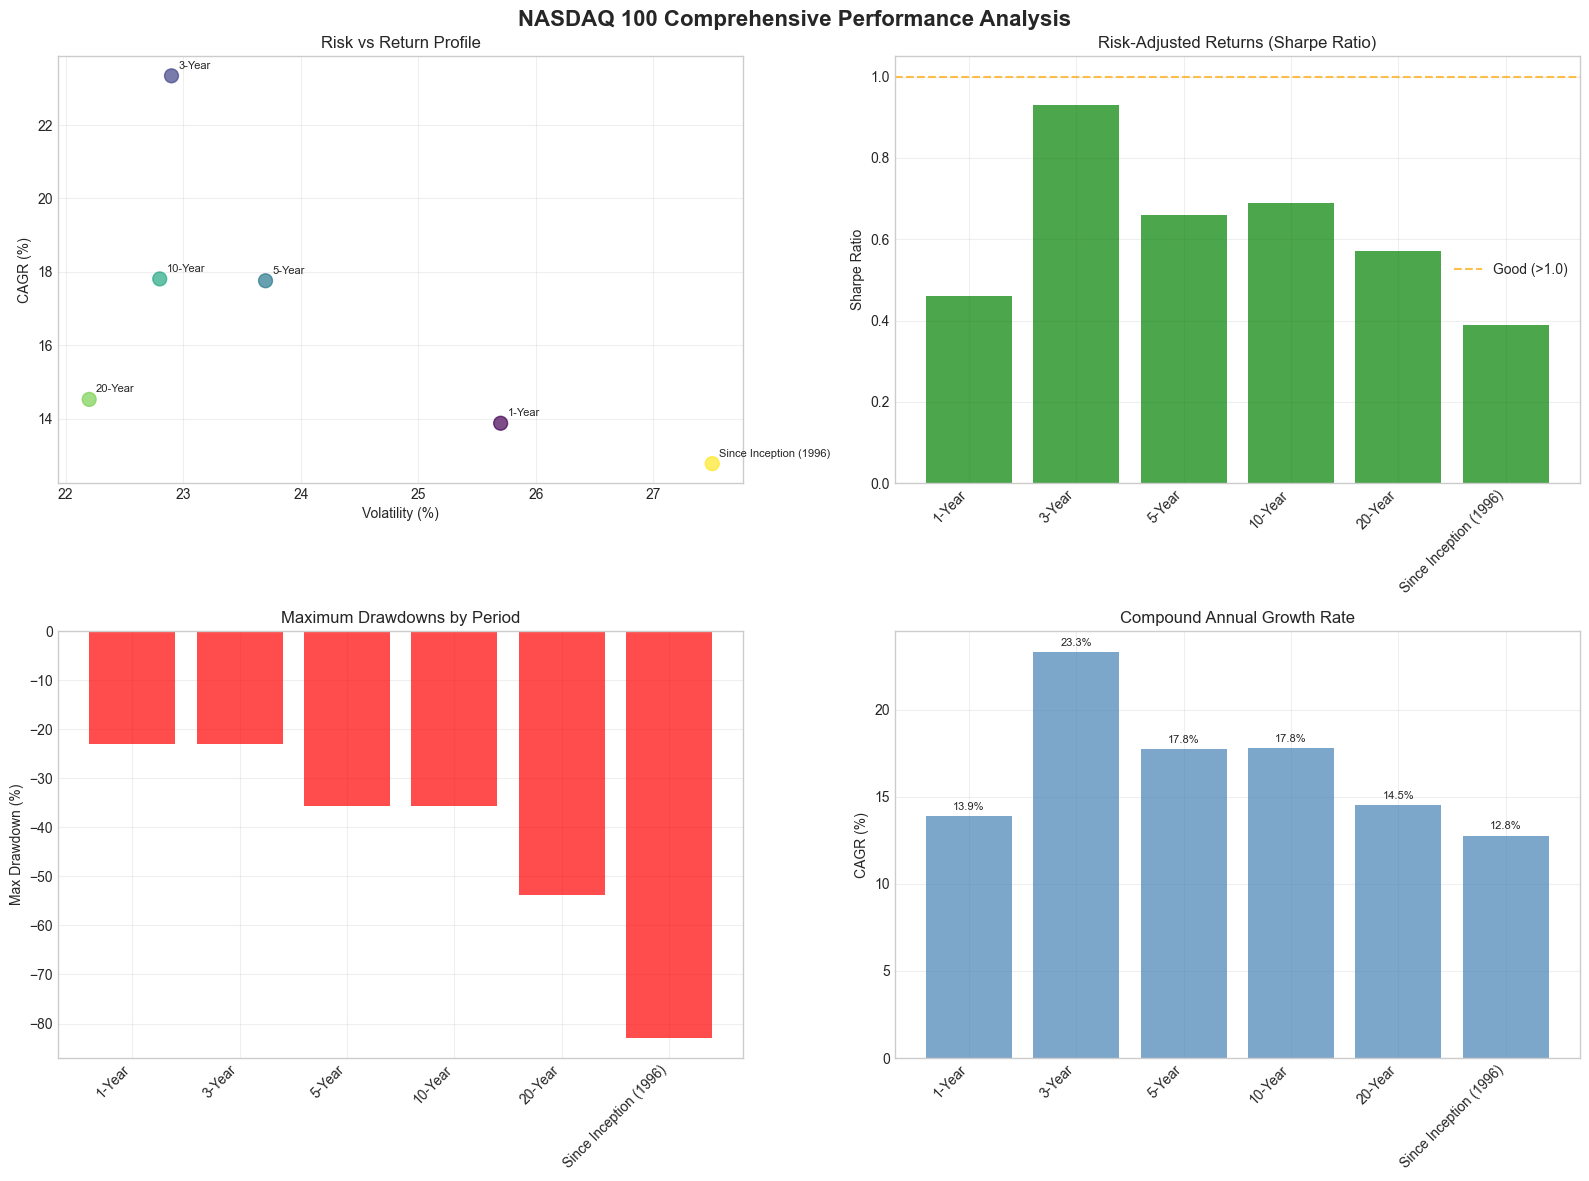

In [86]:
import pandas as pd
import numpy as np
from IPython.display import display

# Load the data
df = pd.read_csv('ndx_historical.csv')

# Data Cleaning and Preparation
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['close'] = df['close'].replace({',': ''}, regex=True).astype(float)
df = df.sort_values('date')

# Set the date as the index
df.set_index('date', inplace=True)

# Get the most recent date
latest_date = df.index.max()

# Function to calculate annualized return
def calculate_annualized_return(end_date, years):
    start_date_target = end_date - pd.DateOffset(years=years)
    
    try:
        actual_start_date = df.index[df.index.searchsorted(start_date_target, side='left')]
        actual_end_date = df.index[df.index.searchsorted(end_date, side='right') - 1]
    except IndexError:
        return None, None, None

    start_price = df.loc[actual_start_date, 'close']
    end_price = df.loc[actual_end_date, 'close']
    
    if isinstance(start_price, pd.Series):
        start_price = start_price.iloc[0]
    if isinstance(end_price, pd.Series):
        end_price = end_price.iloc[-1]

    actual_years = (actual_end_date - actual_start_date).days / 365.25
    
    if actual_years == 0:
        return 0.0, actual_start_date, actual_end_date

    cagr = ((end_price / start_price) ** (1 / actual_years)) - 1
    return cagr * 100, actual_start_date, actual_end_date

# Enhanced function to calculate comprehensive metrics
def calculate_comprehensive_metrics(end_date, years):
    start_date_target = end_date - pd.DateOffset(years=years)
    
    try:
        actual_start_date = df.index[df.index.searchsorted(start_date_target, side='left')]
        actual_end_date = df.index[df.index.searchsorted(end_date, side='right') - 1]
    except IndexError:
        return None

    period_df = df.loc[actual_start_date:actual_end_date].copy()
    
    if len(period_df) < 2:
        return None
    
    start_price = period_df['close'].iloc[0]
    end_price = period_df['close'].iloc[-1]
    
    actual_years = (actual_end_date - actual_start_date).days / 365.25
    
    # Calculate returns - FIX: Add parentheses around the entire CAGR calculation
    cagr = (((end_price / start_price) ** (1 / actual_years)) - 1) * 100
    total_return = ((end_price / start_price) - 1) * 100
    
    # Calculate daily returns for volatility and other metrics
    daily_returns = period_df['close'].pct_change().dropna()
    
    # Volatility (annualized)
    volatility = daily_returns.std() * np.sqrt(252) * 100
    
    # Sharpe ratio (assuming 2% risk-free rate)
    risk_free_rate = 2.0
    sharpe_ratio = (cagr - risk_free_rate) / volatility if volatility > 0 else 0
    
    # Maximum drawdown
    rolling_max = period_df['close'].expanding().max()
    drawdown = (period_df['close'] / rolling_max - 1) * 100
    max_drawdown = drawdown.min()
    
    # Calmar ratio (CAGR / |Max Drawdown|)
    calmar_ratio = cagr / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate (percentage of positive days)
    win_rate = (daily_returns > 0).mean() * 100
    
    # Best and worst day
    best_day = daily_returns.max() * 100
    worst_day = daily_returns.min() * 100
    
    # Positive years percentage
    annual_returns = []
    for year in range(period_df.index.min().year, period_df.index.max().year + 1):
        year_data = period_df[period_df.index.year == year]
        if len(year_data) > 0:
            year_start = year_data['close'].iloc[0]
            year_end = year_data['close'].iloc[-1]
            year_return = ((year_end / year_start) - 1) * 100
            annual_returns.append(year_return)
    
    positive_years = (np.array(annual_returns) > 0).mean() * 100 if annual_returns else 0
    
    return {
        'cagr': cagr,
        'total_return': total_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'win_rate': win_rate,
        'best_day': best_day,
        'worst_day': worst_day,
        'positive_years': positive_years,
        'start_date': actual_start_date,
        'end_date': actual_end_date
    }

# Calculate comprehensive metrics for different periods
periods = [1, 3, 5, 10, 20]
max_years = (latest_date - df.index.min()).days / 365.25

comprehensive_results = []
for p in periods:
    if max_years >= p:
        metrics = calculate_comprehensive_metrics(latest_date, p)
        if metrics:
            comprehensive_results.append({
                "Period": f"{p}-Year",
                "CAGR (%)": f"{metrics['cagr']:.2f}",
                "Total Return (%)": f"{metrics['total_return']:.1f}",
                "Volatility (%)": f"{metrics['volatility']:.1f}",
                "Sharpe Ratio": f"{metrics['sharpe_ratio']:.2f}",
                "Max Drawdown (%)": f"{metrics['max_drawdown']:.1f}",
                "Calmar Ratio": f"{metrics['calmar_ratio']:.2f}",
                "Win Rate (%)": f"{metrics['win_rate']:.1f}",
                "Best Day (%)": f"{metrics['best_day']:.1f}",
                "Worst Day (%)": f"{metrics['worst_day']:.1f}",
                "Positive Years (%)": f"{metrics['positive_years']:.0f}",
                "Start Date": metrics['start_date'].strftime('%Y-%m-%d'),
                "End Date": metrics['end_date'].strftime('%Y-%m-%d')
            })
        else:
            comprehensive_results.append({
                "Period": f"{p}-Year",
                "CAGR (%)": "N/A",
                "Total Return (%)": "N/A",
                "Volatility (%)": "N/A",
                "Sharpe Ratio": "N/A",
                "Max Drawdown (%)": "N/A",
                "Calmar Ratio": "N/A",
                "Win Rate (%)": "N/A",
                "Best Day (%)": "N/A",
                "Worst Day (%)": "N/A",
                "Positive Years (%)": "N/A",
                "Start Date": "-",
                "End Date": "-"
            })

# Add since inception metrics
inception_metrics = calculate_comprehensive_metrics(latest_date, int(max_years))
if inception_metrics:
    comprehensive_results.append({
        "Period": f"Since Inception ({df.index.min().year})",
        "CAGR (%)": f"{inception_metrics['cagr']:.2f}",
        "Total Return (%)": f"{inception_metrics['total_return']:.1f}",
        "Volatility (%)": f"{inception_metrics['volatility']:.1f}",
        "Sharpe Ratio": f"{inception_metrics['sharpe_ratio']:.2f}",
        "Max Drawdown (%)": f"{inception_metrics['max_drawdown']:.1f}",
        "Calmar Ratio": f"{inception_metrics['calmar_ratio']:.2f}",
        "Win Rate (%)": f"{inception_metrics['win_rate']:.1f}",
        "Best Day (%)": f"{inception_metrics['best_day']:.1f}",
        "Worst Day (%)": f"{inception_metrics['worst_day']:.1f}",
        "Positive Years (%)": f"{inception_metrics['positive_years']:.0f}",
        "Start Date": inception_metrics['start_date'].strftime('%Y-%m-%d'),
        "End Date": inception_metrics['end_date'].strftime('%Y-%m-%d')
    })

comprehensive_df = pd.DataFrame(comprehensive_results)

print('=' * 100)
print('NASDAQ 100 COMPREHENSIVE ANNUALIZED RETURNS ANALYSIS')
print('=' * 100)
print('\n📈 BASIC RETURNS:')
basic_display = comprehensive_df[['Period', 'CAGR (%)', 'Total Return (%)', 'Start Date', 'End Date']].copy()
print(basic_display.to_string(index=False))

print('\n⚡ RISK METRICS:')
risk_display = comprehensive_df[['Period', 'Volatility (%)', 'Max Drawdown (%)', 'Sharpe Ratio', 'Calmar Ratio']].copy()
print(risk_display.to_string(index=False))

print('\n📊 CONSISTENCY METRICS:')
consistency_display = comprehensive_df[['Period', 'Win Rate (%)', 'Positive Years (%)', 'Best Day (%)', 'Worst Day (%)']].copy()
print(consistency_display.to_string(index=False))

print('\n🔍 DYNAMIC ANALYSIS & INSIGHTS:')
print('-' * 50)

# Extract numeric values for analysis
numeric_df = comprehensive_df.copy()
for col in ['CAGR (%)', 'Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Calmar Ratio']:
    numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')

# Dynamic analysis based on actual numbers
def analyze_performance_dynamically(numeric_df):
    """Generate dynamic insights based on actual performance metrics"""
    
    # Find best periods for different metrics
    if not numeric_df['CAGR (%)'].isna().all():
        best_cagr_period = numeric_df.loc[numeric_df['CAGR (%)'].idxmax(), 'Period']
        best_cagr_value = numeric_df.loc[numeric_df['CAGR (%)'].idxmax(), 'CAGR (%)']
        worst_cagr_period = numeric_df.loc[numeric_df['CAGR (%)'].idxmin(), 'Period']
        worst_cagr_value = numeric_df.loc[numeric_df['CAGR (%)'].idxmin(), 'CAGR (%)']
        
        print(f"🏆 Best CAGR Period: {best_cagr_period} ({best_cagr_value:.1f}%)")
        print(f"📉 Worst CAGR Period: {worst_cagr_period} ({worst_cagr_value:.1f}%)")
        
        # Dynamic interpretation of CAGR values
        if best_cagr_value > 15:
            print(f"   💡 {best_cagr_value:.1f}% CAGR is EXCELLENT - significantly outperforms market averages")
        elif best_cagr_value > 10:
            print(f"   💡 {best_cagr_value:.1f}% CAGR is STRONG - beats typical market returns")
        elif best_cagr_value > 7:
            print(f"   💡 {best_cagr_value:.1f}% CAGR is GOOD - solid long-term growth")
        else:
            print(f"   💡 {best_cagr_value:.1f}% CAGR is MODEST - consider market conditions")
    
    print()
    
    # Volatility analysis with dynamic interpretation
    if not numeric_df['Volatility (%)'].isna().all():
        avg_volatility = numeric_df['Volatility (%)'].mean()
        highest_vol_period = numeric_df.loc[numeric_df['Volatility (%)'].idxmax(), 'Period']
        highest_vol_value = numeric_df.loc[numeric_df['Volatility (%)'].idxmax(), 'Volatility (%)']
        lowest_vol_period = numeric_df.loc[numeric_df['Volatility (%)'].idxmin(), 'Period']
        lowest_vol_value = numeric_df.loc[numeric_df['Volatility (%)'].idxmin(), 'Volatility (%)']
        
        print(f"📊 VOLATILITY ANALYSIS:")
        print(f"   Average Volatility: {avg_volatility:.1f}%")
        print(f"   Highest Volatility: {highest_vol_period} ({highest_vol_value:.1f}%)")
        print(f"   Lowest Volatility: {lowest_vol_period} ({lowest_vol_value:.1f}%)")
        
        # Dynamic volatility interpretation
        if avg_volatility > 25:
            print(f"   💡 Average volatility of {avg_volatility:.1f}% is HIGH - expect significant price swings")
        elif avg_volatility > 20:
            print(f"   💡 Average volatility of {avg_volatility:.1f}% is MODERATE-HIGH - typical for growth stocks")
        elif avg_volatility > 15:
            print(f"   💡 Average volatility of {avg_volatility:.1f}% is MODERATE - balanced risk/reward")
        else:
            print(f"   💡 Average volatility of {avg_volatility:.1f}% is LOW - relatively stable performance")
    
    print()
    
    # Sharpe Ratio analysis with dynamic interpretation
    if not numeric_df['Sharpe Ratio'].isna().all():
        best_sharpe_period = numeric_df.loc[numeric_df['Sharpe Ratio'].idxmax(), 'Period']
        best_sharpe_value = numeric_df.loc[numeric_df['Sharpe Ratio'].idxmax(), 'Sharpe Ratio']
        avg_sharpe = numeric_df['Sharpe Ratio'].mean()
        
        print(f"📈 RISK-ADJUSTED PERFORMANCE:")
        print(f"   Best Sharpe Ratio: {best_sharpe_period} ({best_sharpe_value:.2f})")
        print(f"   Average Sharpe Ratio: {avg_sharpe:.2f}")
        
        # Dynamic Sharpe ratio interpretation
        if best_sharpe_value > 1.5:
            print(f"   💰 Sharpe ratio of {best_sharpe_value:.2f} is EXCELLENT - great risk-adjusted returns")
        elif best_sharpe_value > 1.0:
            print(f"   💰 Sharpe ratio of {best_sharpe_value:.2f} is GOOD - decent risk-adjusted returns")
        elif best_sharpe_value > 0.5:
            print(f"   💰 Sharpe ratio of {best_sharpe_value:.2f} is ACCEPTABLE - moderate risk compensation")
        else:
            print(f"   💰 Sharpe ratio of {best_sharpe_value:.2f} is POOR - insufficient risk compensation")
        
        if avg_sharpe > 1.0:
            print(f"   💡 Average Sharpe of {avg_sharpe:.2f} suggests consistently good risk-adjusted performance across periods")
        else:
            print(f"   💡 Average Sharpe of {avg_sharpe:.2f} suggests room for improvement in risk-adjusted returns")
    
    print()
    
    # Maximum Drawdown analysis with dynamic interpretation
    if not numeric_df['Max Drawdown (%)'].isna().all():
        lowest_drawdown_period = numeric_df.loc[numeric_df['Max Drawdown (%)'].idxmax(), 'Period']
        lowest_drawdown_value = numeric_df.loc[numeric_df['Max Drawdown (%)'].idxmax(), 'Max Drawdown (%)']
        worst_drawdown_period = numeric_df.loc[numeric_df['Max Drawdown (%)'].idxmin(), 'Period']
        worst_drawdown_value = numeric_df.loc[numeric_df['Max Drawdown (%)'].idxmin(), 'Max Drawdown (%)']
        
        print(f"🛡️  DRAWDOWN ANALYSIS:")
        print(f"   Best (Lowest) Drawdown: {lowest_drawdown_period} ({lowest_drawdown_value:.1f}%)")
        print(f"   Worst (Highest) Drawdown: {worst_drawdown_period} ({worst_drawdown_value:.1f}%)")
        
        # Dynamic drawdown interpretation
        if abs(worst_drawdown_value) > 50:
            print(f"   ⚠️  {worst_drawdown_value:.1f}% drawdown is SEVERE - you'd need strong conviction to hold through this")
        elif abs(worst_drawdown_value) > 30:
            print(f"   ⚠️  {worst_drawdown_value:.1f}% drawdown is SIGNIFICANT - challenging but manageable for long-term investors")
        elif abs(worst_drawdown_value) > 20:
            print(f"   ⚠️  {worst_drawdown_value:.1f}% drawdown is MODERATE - typical for equity investments")
        else:
            print(f"   ⚠️  {worst_drawdown_value:.1f}% drawdown is MILD - relatively low risk")
    
    print()
    
    # Win rate analysis with dynamic interpretation
    win_rates = []
    positive_years = []
    for _, row in numeric_df.iterrows():
        win_rate_str = comprehensive_df.loc[comprehensive_df['Period'] == row['Period'], 'Win Rate (%)'].iloc[0]
        pos_years_str = comprehensive_df.loc[comprehensive_df['Period'] == row['Period'], 'Positive Years (%)'].iloc[0]
        
        if win_rate_str != 'N/A':
            win_rates.append(float(win_rate_str))
        if pos_years_str != 'N/A':
            positive_years.append(float(pos_years_str))
    
    if win_rates:
        avg_win_rate = np.mean(win_rates)
        print(f"🎯 CONSISTENCY ANALYSIS:")
        print(f"   Average Daily Win Rate: {avg_win_rate:.1f}%")
        
        if avg_win_rate > 55:
            print(f"   💡 {avg_win_rate:.1f}% win rate is HIGH - more up days than typical")
        elif avg_win_rate > 50:
            print(f"   💡 {avg_win_rate:.1f}% win rate is NORMAL - balanced up/down days")
        else:
            print(f"   💡 {avg_win_rate:.1f}% win rate is BELOW AVERAGE - more down days than up")
    
    if positive_years:
        avg_pos_years = np.mean(positive_years)
        print(f"   Average Positive Years: {avg_pos_years:.0f}%")
        
        if avg_pos_years > 80:
            print(f"   💡 {avg_pos_years:.0f}% positive years is EXCELLENT - very reliable year-over-year")
        elif avg_pos_years > 70:
            print(f"   💡 {avg_pos_years:.0f}% positive years is GOOD - mostly positive annually")
        elif avg_pos_years > 60:
            print(f"   💡 {avg_pos_years:.0f}% positive years is DECENT - reasonably consistent")
        else:
            print(f"   💡 {avg_pos_years:.0f}% positive years is CONCERNING - many negative years")

# Run the dynamic analysis
analyze_performance_dynamically(numeric_df)

print('\n📚 QUICK METRIC REFERENCE:')
print('-' * 50)
print('• CAGR: Annual growth rate (>10% is strong, >15% is excellent)')
print('• Volatility: Price fluctuation (>25% is high, <15% is low)')
print('• Sharpe Ratio: Risk-adjusted return (>1.0 is good, >1.5 is excellent)')
print('• Max Drawdown: Worst loss from peak (<-20% is mild, >-50% is severe)')
print('• Win Rate: % positive days (>55% is high, <50% is concerning)')
print('• Positive Years: % profitable years (>70% is good, >80% is excellent)')

import matplotlib.pyplot as plt
import seaborn as sns

# Create enhanced visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('NASDAQ 100 Comprehensive Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: CAGR vs Volatility (Risk-Return Scatter)
valid_data = numeric_df.dropna(subset=['CAGR (%)', 'Volatility (%)'])
if not valid_data.empty:
    scatter = ax1.scatter(valid_data['Volatility (%)'], valid_data['CAGR (%)'], 
                         s=100, alpha=0.7, c=range(len(valid_data)), cmap='viridis')
    for i, row in valid_data.iterrows():
        ax1.annotate(row['Period'], (row['Volatility (%)'], row['CAGR (%)']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax1.set_xlabel('Volatility (%)')
    ax1.set_ylabel('CAGR (%)')
    ax1.set_title('Risk vs Return Profile')
    ax1.grid(True, alpha=0.3)

# Plot 2: Sharpe Ratios
valid_sharpe = numeric_df.dropna(subset=['Sharpe Ratio'])
if not valid_sharpe.empty:
    bars = ax2.bar(range(len(valid_sharpe)), valid_sharpe['Sharpe Ratio'], 
                   color=['green' if x > 0 else 'red' for x in valid_sharpe['Sharpe Ratio']], alpha=0.7)
    ax2.set_xticks(range(len(valid_sharpe)))
    ax2.set_xticklabels(valid_sharpe['Period'], rotation=45, ha='right')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.set_title('Risk-Adjusted Returns (Sharpe Ratio)')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.7, label='Good (>1.0)')
    ax2.legend()

# Plot 3: Maximum Drawdowns
valid_drawdown = numeric_df.dropna(subset=['Max Drawdown (%)'])
if not valid_drawdown.empty:
    bars = ax3.bar(range(len(valid_drawdown)), valid_drawdown['Max Drawdown (%)'], 
                   color='red', alpha=0.7)
    ax3.set_xticks(range(len(valid_drawdown)))
    ax3.set_xticklabels(valid_drawdown['Period'], rotation=45, ha='right')
    ax3.set_ylabel('Max Drawdown (%)')
    ax3.set_title('Maximum Drawdowns by Period')
    ax3.grid(True, alpha=0.3)

# Plot 4: CAGR Comparison
valid_cagr = numeric_df.dropna(subset=['CAGR (%)'])
if not valid_cagr.empty:
    bars = ax4.bar(range(len(valid_cagr)), valid_cagr['CAGR (%)'], 
                   color='steelblue', alpha=0.7)
    ax4.set_xticks(range(len(valid_cagr)))
    ax4.set_xticklabels(valid_cagr['Period'], rotation=45, ha='right')
    ax4.set_ylabel('CAGR (%)')
    ax4.set_title('Compound Annual Growth Rate')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.annotate(f'{height:.1f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [79]:
# Function to create charts for different time periods
def create_period_chart(df, period_name, days=None, years=None):
    """
    Create a chart for a specific time period
    """
    # Calculate the start date based on the period
    end_date = df.index.max()
    
    if days:
        start_date = end_date - pd.Timedelta(days=days)
    elif years:
        start_date = end_date - pd.DateOffset(years=years)
    else:
        start_date = df.index.min()
    
    # Filter data for the period
    period_df = df[df.index >= start_date].copy()
    
    if len(period_df) == 0:
        print(f"No data available for {period_name}")
        return
    
    # Create the plot
    plt.figure(figsize=(12, 7))
    
    # Plot the close price
    plt.plot(period_df.index, period_df['close'], linewidth=1.5, alpha=0.8, 
             label=f'NASDAQ 100 Close Price ({period_name})', color='steelblue')
    
    # Add trend line if we have enough data points
    if len(period_df) > 2:
        date_ordinal = period_df.index.map(pd.Timestamp.toordinal)
        z = np.polyfit(date_ordinal, period_df['close'], 1)
        p = np.poly1d(z)
        plt.plot(period_df.index, p(date_ordinal), "r--", linewidth=2, label='Trend Line')
    
    # Formatting
    plt.title(f'NASDAQ 100 Close Price - {period_name}', fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price ($)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Format y-axis to show currency
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    plt.show()
    
    # Print statistics
    start_price = period_df['close'].iloc[0]
    end_price = period_df['close'].iloc[-1]
    min_price = period_df['close'].min()
    max_price = period_df['close'].max()
    total_return = ((end_price / start_price) - 1) * 100
    
    print(f"\n{period_name} Statistics:")
    print(f"Period: {period_df.index.min().strftime('%Y-%m-%d')} to {period_df.index.max().strftime('%Y-%m-%d')}")
    print(f"Starting price: ${start_price:,.2f}")
    print(f"Ending price: ${end_price:,.2f}")
    print(f"Total return: {total_return:.1f}%")
    print(f"Highest price: ${max_price:,.2f}")
    print(f"Lowest price: ${min_price:,.2f}")
    print("-" * 50)

# 📊 NASDAQ 100 Comprehensive Dashboard & Analysis Report

This section provides a unified view of all time periods and a detailed analysis of the NASDAQ 100 performance.

Creating NASDAQ 100 Comprehensive Dashboard...


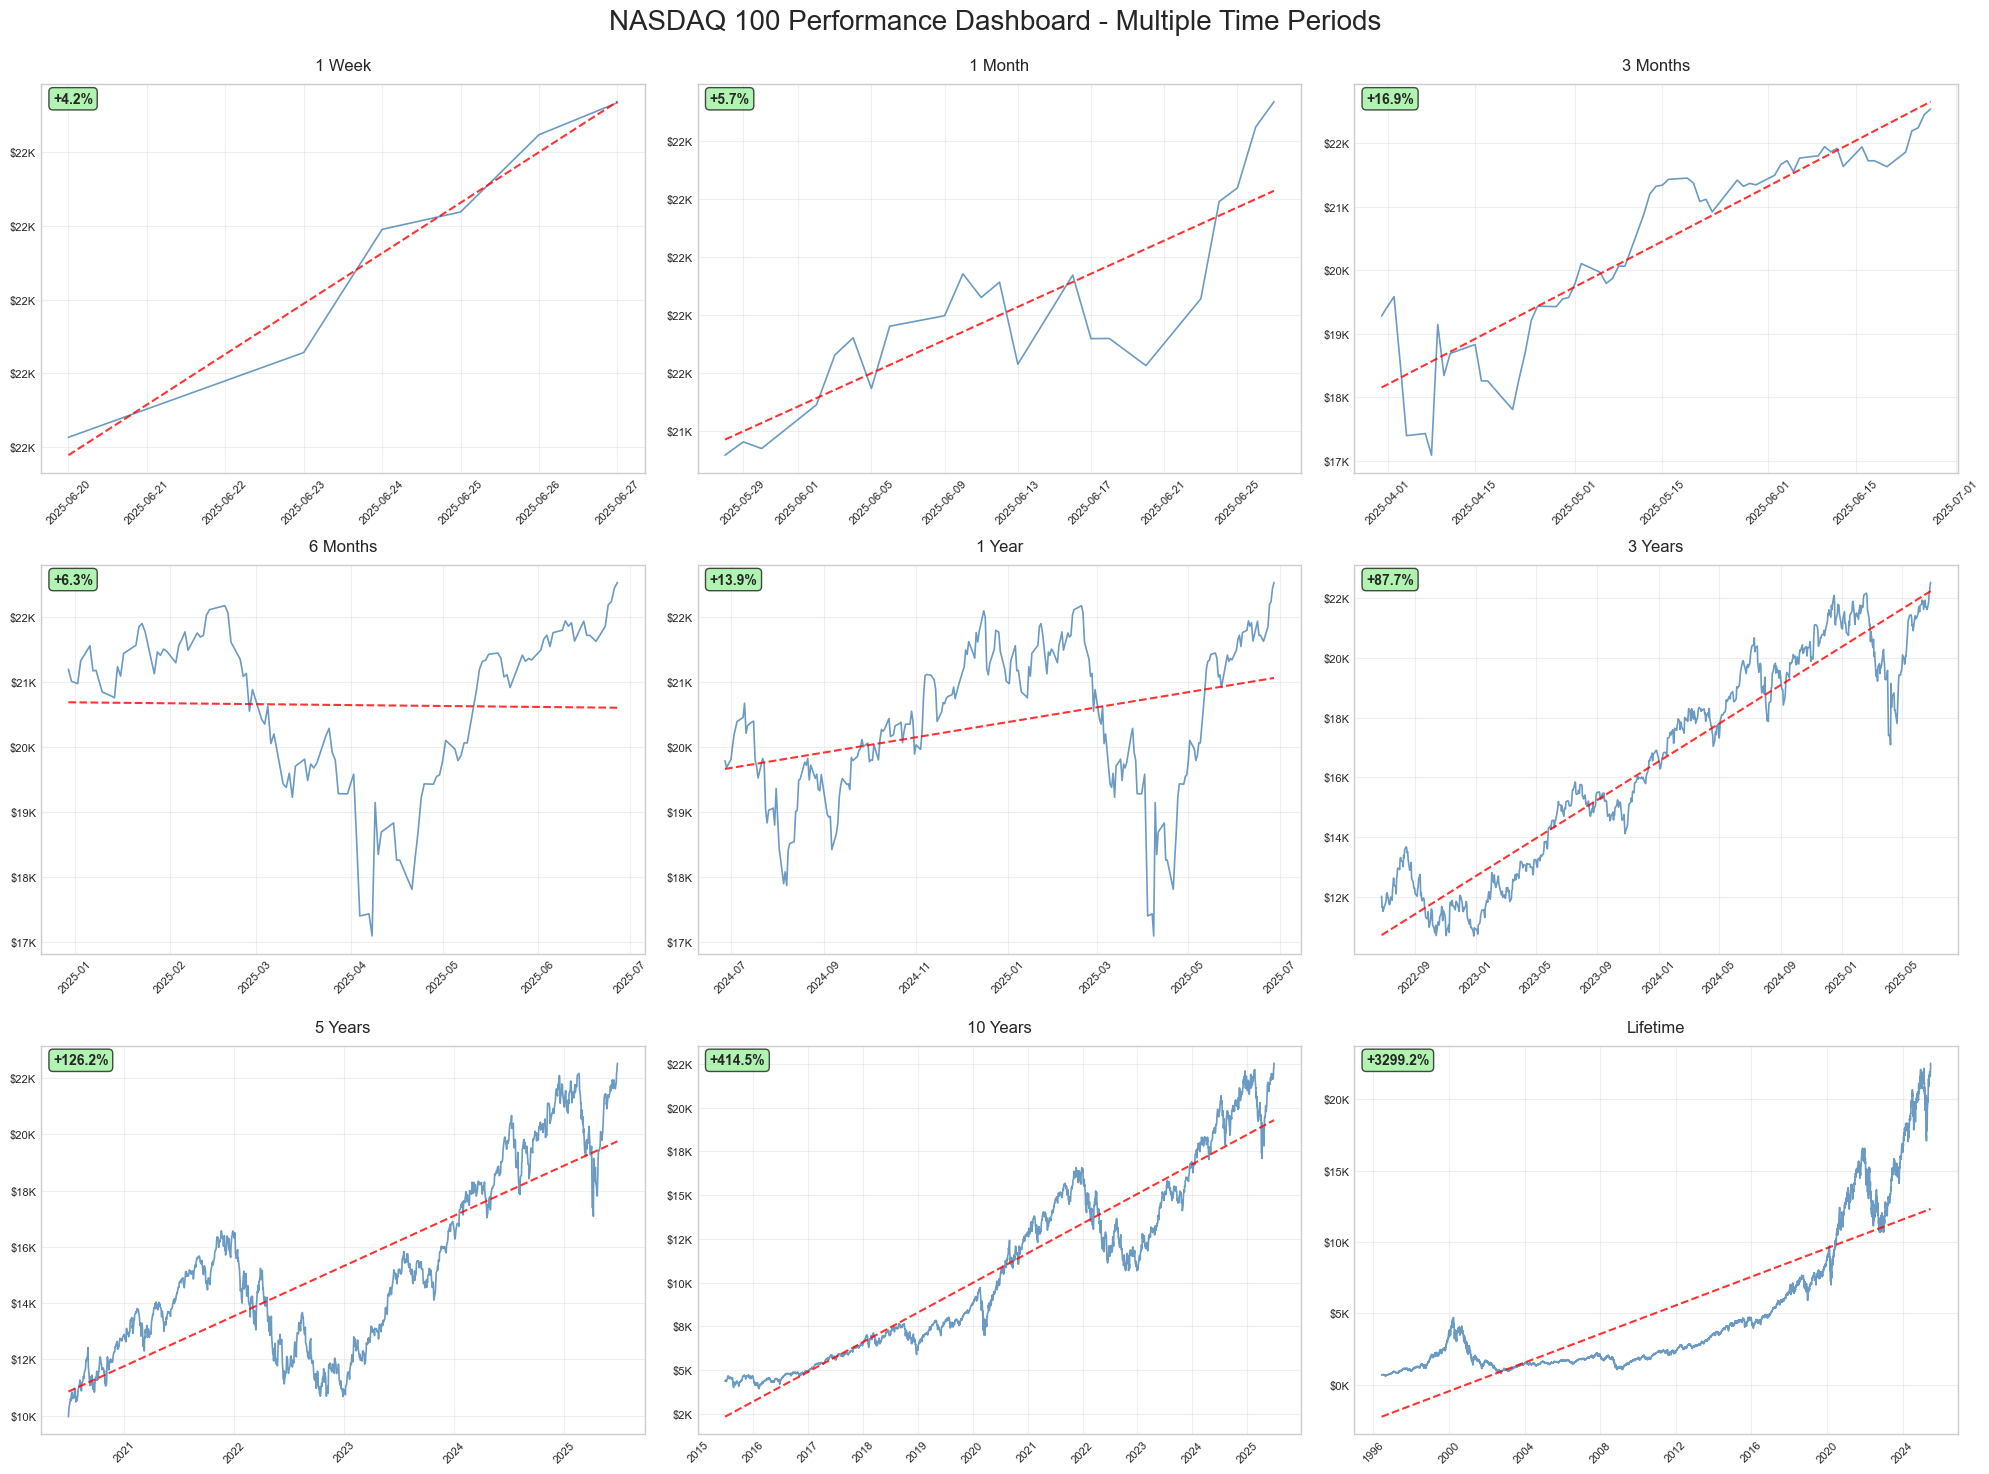

In [80]:
# Create comprehensive dashboard with all time periods
def create_comprehensive_dashboard(df):
    """
    Create a dashboard with all time periods in one figure
    """
    # Define time periods
    periods = [
        ("1 Week", 7, None),
        ("1 Month", 30, None),
        ("3 Months", 90, None),
        ("6 Months", 180, None),
        ("1 Year", None, 1),
        ("3 Years", None, 3),
        ("5 Years", None, 5),
        ("10 Years", None, 10),
        ("Lifetime", None, None)
    ]
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('NASDAQ 100 Performance Dashboard - Multiple Time Periods', fontsize=20, y=0.98)
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()
    
    # Calculate statistics for each period
    stats_data = []
    
    for i, (period_name, days, years) in enumerate(periods):
        ax = axes_flat[i]
        
        # Calculate date range
        end_date = df.index.max()
        if days:
            start_date = end_date - pd.Timedelta(days=days)
        elif years:
            start_date = end_date - pd.DateOffset(years=years)
        else:
            start_date = df.index.min()
        
        # Filter data
        period_df = df[df.index >= start_date].copy()
        
        if len(period_df) == 0:
            ax.text(0.5, 0.5, f'No data for {period_name}', ha='center', va='center', transform=ax.transAxes)
            continue
        
        # Plot data
        ax.plot(period_df.index, period_df['close'], linewidth=1.2, alpha=0.8, color='steelblue')
        
        # Add trend line
        if len(period_df) > 2:
            date_ordinal = period_df.index.map(pd.Timestamp.toordinal)
            z = np.polyfit(date_ordinal, period_df['close'], 1)
            p = np.poly1d(z)
            ax.plot(period_df.index, p(date_ordinal), "r--", linewidth=1.5, alpha=0.8)
        
        # Formatting
        ax.set_title(f'{period_name}', fontsize=12, pad=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        
        # Format y-axis
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K' if x < 10000 else f'${x/1000:.0f}K'))
        
        # Calculate statistics
        start_price = period_df['close'].iloc[0]
        end_price = period_df['close'].iloc[-1]
        total_return = ((end_price / start_price) - 1) * 100
        max_price = period_df['close'].max()
        min_price = period_df['close'].min()
        
        # Add return percentage as text on subplot
        ax.text(0.02, 0.98, f'+{total_return:.1f}%' if total_return >= 0 else f'{total_return:.1f}%', 
                transform=ax.transAxes, fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen' if total_return >= 0 else 'lightcoral', alpha=0.7),
                verticalalignment='top')
        
        # Store statistics
        stats_data.append({
            'Period': period_name,
            'Start Date': period_df.index.min().strftime('%Y-%m-%d'),
            'End Date': period_df.index.max().strftime('%Y-%m-%d'),
            'Start Price': start_price,
            'End Price': end_price,
            'Total Return (%)': total_return,
            'Max Price': max_price,
            'Min Price': min_price,
            'Days': len(period_df)
        })
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    return stats_data

# Create the dashboard
print("Creating NASDAQ 100 Comprehensive Dashboard...")
dashboard_stats = create_comprehensive_dashboard(df)

In [81]:
# Create comprehensive analysis report
def create_analysis_report(stats_data, df):
    """
    Generate a comprehensive analysis report
    """
    print("="*80)
    print("📈 NASDAQ 100 COMPREHENSIVE ANALYSIS REPORT")
    print("="*80)
    print(f"Report Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Data Period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(f"Total Trading Days: {len(df):,}")
    print()
    
    # Create DataFrame from statistics
    stats_df = pd.DataFrame(stats_data)
    
    print("📊 PERFORMANCE SUMMARY BY TIME PERIOD")
    print("-" * 80)
    
    # Format and display the statistics table
    display_df = stats_df.copy()
    display_df['Start Price'] = display_df['Start Price'].apply(lambda x: f'${x:,.2f}')
    display_df['End Price'] = display_df['End Price'].apply(lambda x: f'${x:,.2f}')
    display_df['Total Return (%)'] = display_df['Total Return (%)'].apply(lambda x: f'{x:+.1f}%')
    display_df['Max Price'] = display_df['Max Price'].apply(lambda x: f'${x:,.2f}')
    display_df['Min Price'] = display_df['Min Price'].apply(lambda x: f'${x:,.2f}')
    
    print(display_df.to_string(index=False))
    print()
    
    # Key insights
    print("🔍 KEY INSIGHTS & ANALYSIS")
    print("-" * 80)
    
    # Best and worst performing periods
    best_period = stats_df.loc[stats_df['Total Return (%)'].idxmax()]
    worst_period = stats_df.loc[stats_df['Total Return (%)'].idxmin()]
    
    print(f"🟢 Best Performing Period: {best_period['Period']} (+{best_period['Total Return (%)']:.1f}%)")
    print(f"🔴 Worst Performing Period: {worst_period['Period']} ({worst_period['Total Return (%)']:.1f}%)")
    print()
    
    # Current market metrics
    current_price = df['close'].iloc[-1]
    lifetime_start = df['close'].iloc[0]
    all_time_high = df['close'].max()
    all_time_low = df['close'].min()
    
    print("📍 CURRENT MARKET POSITION")
    print("-" * 40)
    print(f"Current Price: ${current_price:,.2f}")
    print(f"All-Time High: ${all_time_high:,.2f}")
    print(f"All-Time Low: ${all_time_low:,.2f}")
    print(f"Distance from ATH: {((current_price/all_time_high - 1) * 100):+.1f}%")
    print(f"Distance from ATL: +{((current_price/all_time_low - 1) * 100):.0f}%")
    print()
    
    # Volatility analysis
    print("📊 VOLATILITY ANALYSIS")
    print("-" * 40)
    daily_returns = df['close'].pct_change().dropna()
    volatility_30d = daily_returns.tail(30).std() * np.sqrt(252) * 100
    volatility_1y = daily_returns.tail(252).std() * np.sqrt(252) * 100
    volatility_lifetime = daily_returns.std() * np.sqrt(252) * 100
    
    print(f"30-Day Annualized Volatility: {volatility_30d:.1f}%")
    print(f"1-Year Annualized Volatility: {volatility_1y:.1f}%")
    print(f"Lifetime Annualized Volatility: {volatility_lifetime:.1f}%")
    print()
    
    # CAGR calculations
    print("📈 COMPOUND ANNUAL GROWTH RATE (CAGR)")
    print("-" * 40)
    years_total = (df.index.max() - df.index.min()).days / 365.25
    lifetime_cagr = ((current_price / lifetime_start) ** (1/years_total) - 1) * 100
    
    print(f"Lifetime CAGR ({years_total:.1f} years): {lifetime_cagr:.1f}%")
    
    # Calculate CAGR for different periods
    cagr_periods = [(1, 'year'), (3, 'years'), (5, 'years'), (10, 'years')]
    for period_years, unit in cagr_periods:
        period_data = stats_df[stats_df['Period'] == f'{period_years} Year{"s" if period_years > 1 else ""}']
        if not period_data.empty:
            period_return = period_data['Total Return (%)'].iloc[0]
            cagr = ((1 + period_return/100) ** (1/period_years) - 1) * 100
            print(f"{period_years} {unit.title()} CAGR: {cagr:.1f}%")
    print()
    
    # Market phases analysis
    print("🔄 MARKET PHASES ANALYSIS")
    print("-" * 40)
    
    # Identify major drawdowns
    rolling_max = df['close'].expanding().max()
    drawdown = (df['close'] / rolling_max - 1) * 100
    max_drawdown = drawdown.min()
    
    print(f"Maximum Historical Drawdown: {max_drawdown:.1f}%")
    
    # Recovery analysis
    current_drawdown = drawdown.iloc[-1]
    if current_drawdown < -1:
        print(f"Current Drawdown: {current_drawdown:.1f}%")
    else:
        print("Currently near all-time highs")
    
    print()
    
    # Investment scenarios
    print("💰 INVESTMENT SCENARIOS (Hypothetical)")
    print("-" * 40)
    investment_amounts = [1000, 10000, 100000]
    
    for amount in investment_amounts:
        lifetime_value = amount * (current_price / lifetime_start)
        print(f"${amount:,} invested in 1996 → ${lifetime_value:,.0f} today ({((lifetime_value/amount - 1) * 100):,.0f}% return)")
    
    print()
    print("⚠️  IMPORTANT DISCLAIMERS")
    print("-" * 40)
    print("• Past performance does not guarantee future results")
    print("• This analysis is for educational purposes only")
    print("• Always consult with a financial advisor before making investment decisions")
    print("• Index investing involves market risk and potential loss of principal")
    print("="*80)

# Generate the comprehensive report
create_analysis_report(dashboard_stats, df)

📈 NASDAQ 100 COMPREHENSIVE ANALYSIS REPORT
Report Generated: 2025-07-01 02:02:00
Data Period: 1996-06-06 to 2025-06-27
Total Trading Days: 7,491

📊 PERFORMANCE SUMMARY BY TIME PERIOD
--------------------------------------------------------------------------------
  Period Start Date   End Date Start Price  End Price Total Return (%)  Max Price  Min Price  Days
  1 Week 2025-06-20 2025-06-27  $21,626.39 $22,534.20            +4.2% $22,534.20 $21,626.39     6
 1 Month 2025-05-28 2025-06-27  $21,318.17 $22,534.20            +5.7% $22,534.20 $21,318.17    22
3 Months 2025-03-31 2025-06-27  $19,278.45 $22,534.20           +16.9% $22,534.20 $17,090.40    62
6 Months 2024-12-30 2025-06-27  $21,197.09 $22,534.20            +6.3% $22,534.20 $17,090.40   123
  1 Year 2024-06-27 2025-06-27  $19,789.03 $22,534.20           +13.9% $22,534.20 $17,090.40   251
 3 Years 2022-06-27 2025-06-27  $12,008.24 $22,534.20           +87.7% $22,534.20 $10,679.34   754
 5 Years 2020-06-29 2025-06-27   $9,961.16 